##  OCT Post-processing

Demostrates using regression techniques to produce OCT boundary estimates from dense (per-pixel) CNN estimates.


In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import h5py

import sys, time
import numpy as np
import pylab as plt
from scipy.io import loadmat

import GPy                       # provides Gaussian process implementation - you will have to install this

sys.path.append('../..')
import cnn_tools as ct
import train_oct
import postproc_oct as ppo

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Loading Data

We begin by loading some dense estimates that were computed remotely.  At this point in the processing chain we are finished with CNNs and Keras; the remaining calculations are just vanilla linear algebra.

In [2]:
f = np.load('oct_seg_fold0_deploy_final_nomirror.npz')

X = f['X']
Y = f['Y']
Y_hat = f['Y_hat']
test_slices = f['test_slices']
valid_slices = f['valid_slices']

train_slices = [x for x in range(50) if x not in test_slices and x not in valid_slices]

print('X shape:     ', X.shape)
print('Y shape:     ', Y.shape)
print('Y_hat shape: ', Y_hat.shape)
print('test slices are: ', test_slices)

X shape:      (50, 1, 512, 768)
Y shape:      (50, 1, 512, 768)
Y_hat shape:  (50, 512, 768)
test slices are:  [ 0  5 10 15 20 25 30 35 40 45]


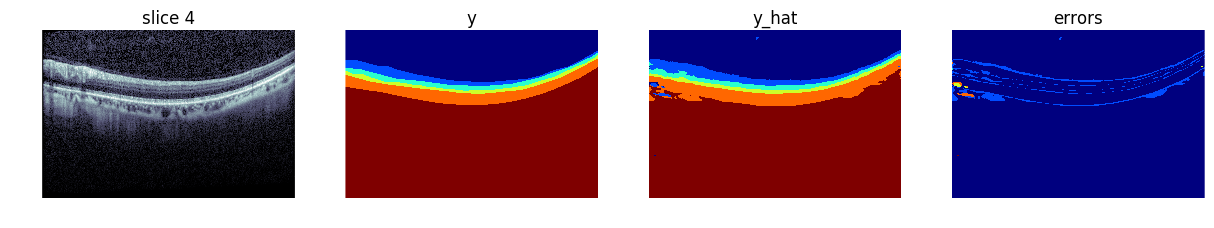

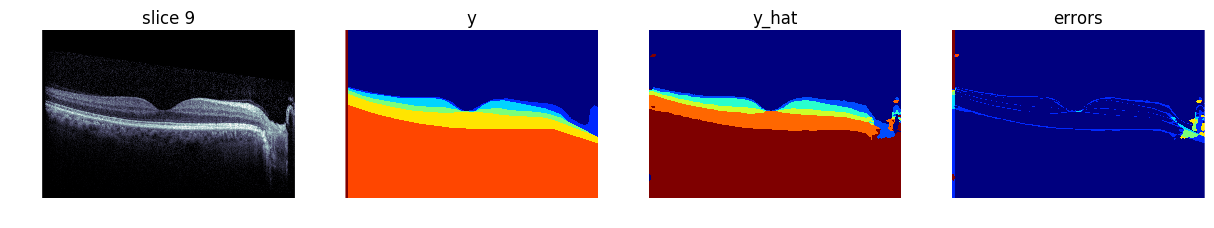

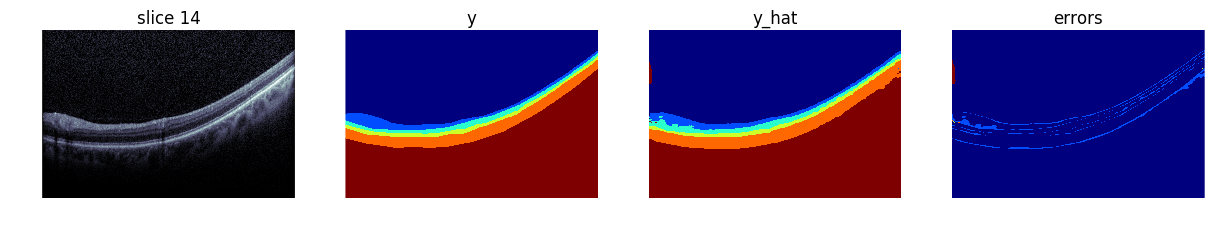

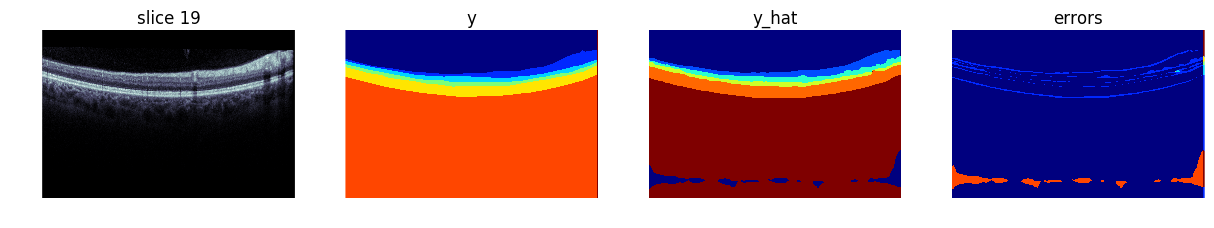

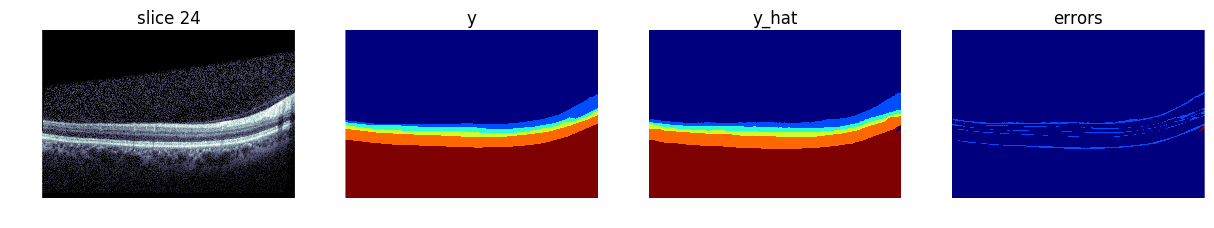

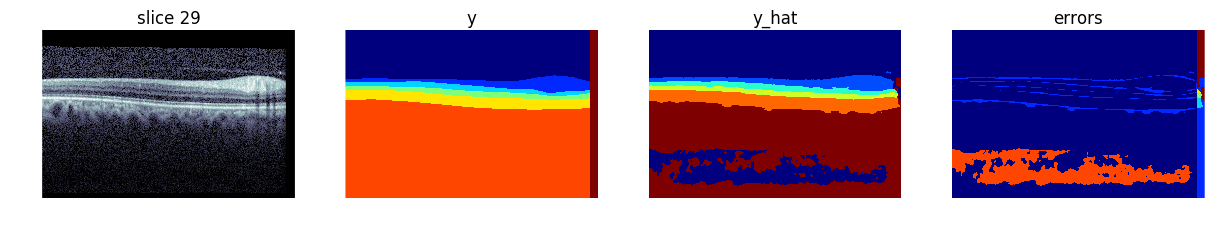

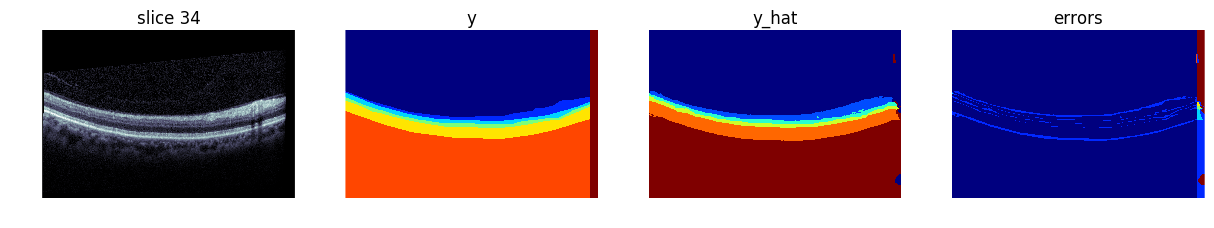

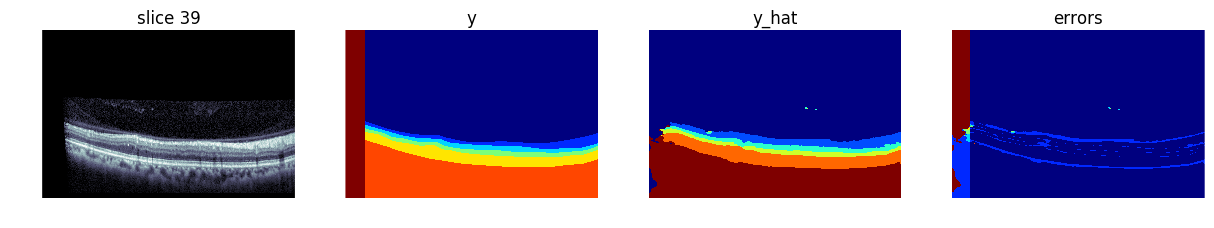

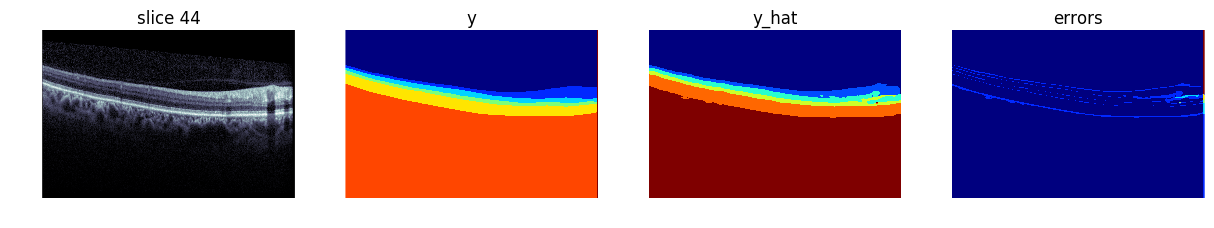

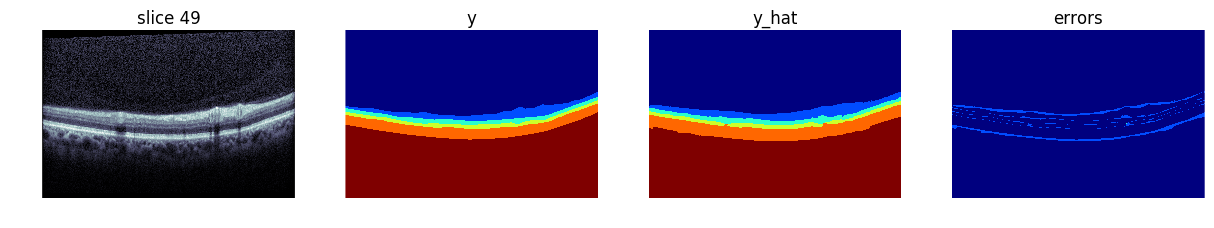

In [3]:
slices_to_view = valid_slices[:10]

for ts in slices_to_view:
    xi = np.squeeze(X[ts,...])
    yi = np.squeeze(Y[ts,...])
    yi_hat = Y_hat[ts,...]
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,4,1)
    plt.imshow(xi, interpolation='none', cmap='bone')
    plt.axis('off')
    plt.title('slice %d' % ts)
    
    plt.subplot(1,4,2)
    #plt.imshow(xi, interpolation='none', cmap='bone')
    plt.imshow(yi, interpolation='none', cmap='jet')
    plt.axis('off')
    plt.title('y')
    
    plt.subplot(1,4,3)
    plt.imshow(yi_hat, interpolation='none')
    plt.axis('off')
    plt.title('y_hat')
    
    plt.subplot(1,4,4)
    plt.imshow(np.abs(yi - yi_hat), interpolation='none')
    plt.axis('off')
    plt.title('errors')
    
    

## Regression demonstration

(512, 768)
(10, 512, 768)


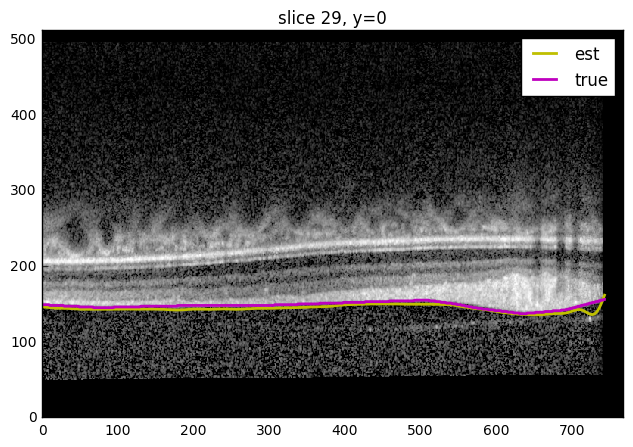

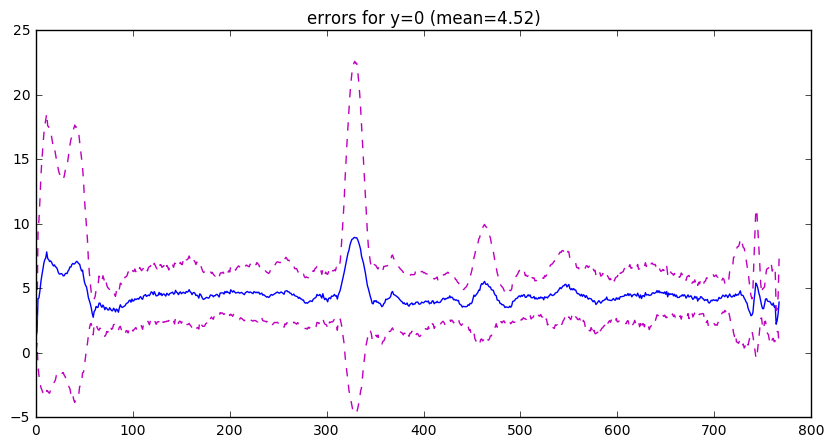

(512, 768)
(10, 512, 768)


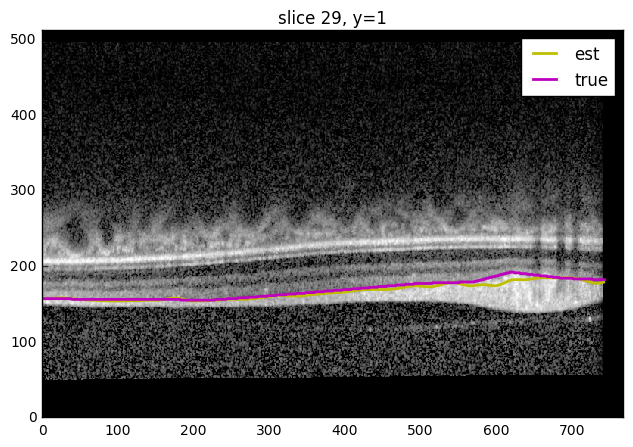

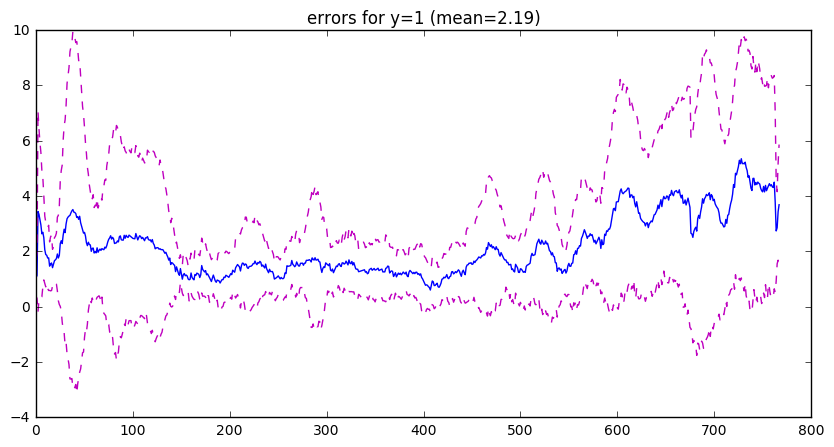

(512, 768)
(10, 512, 768)


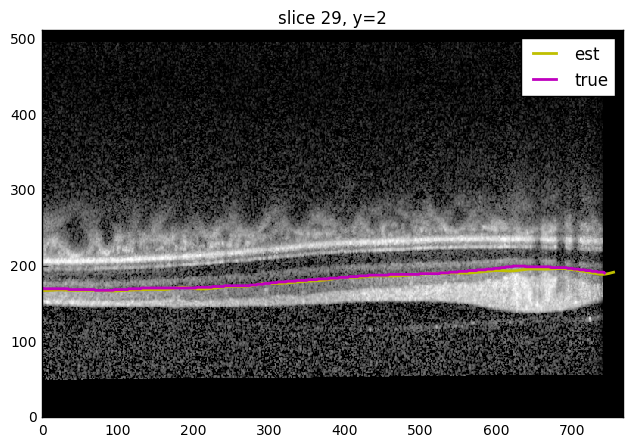

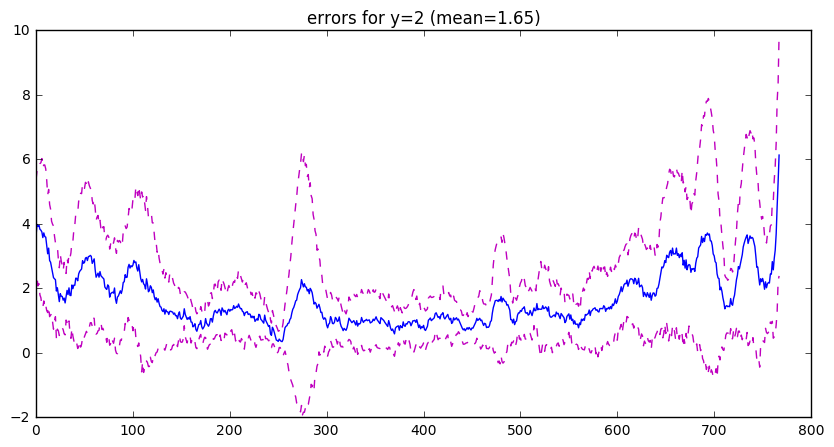

(512, 768)
(10, 512, 768)


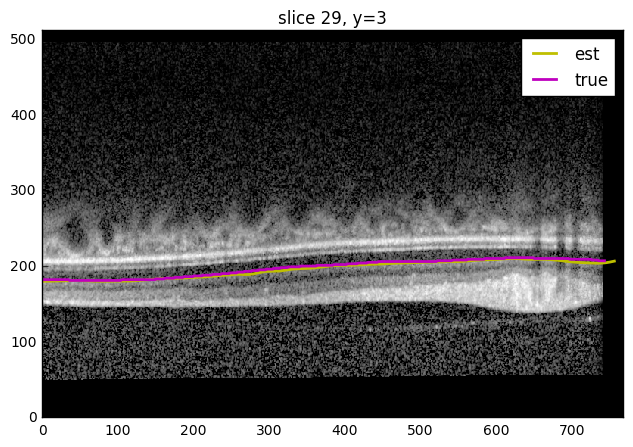

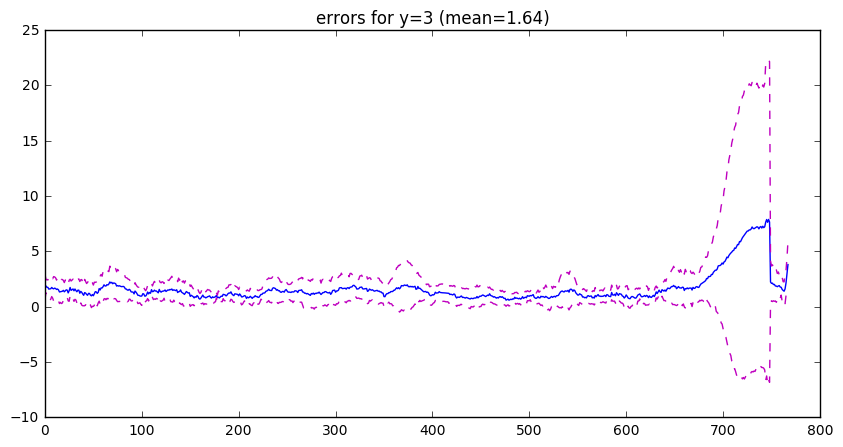

(512, 768)
(10, 512, 768)


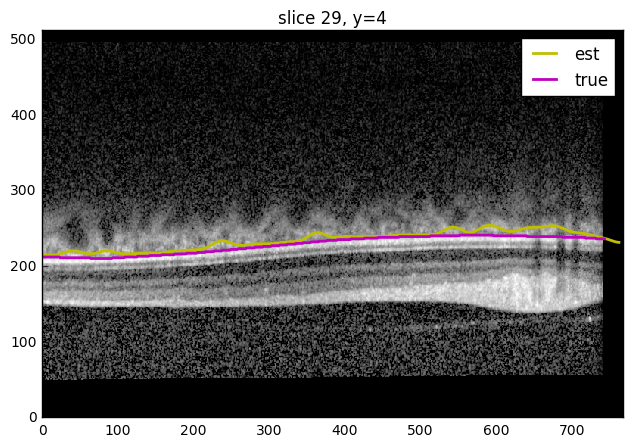

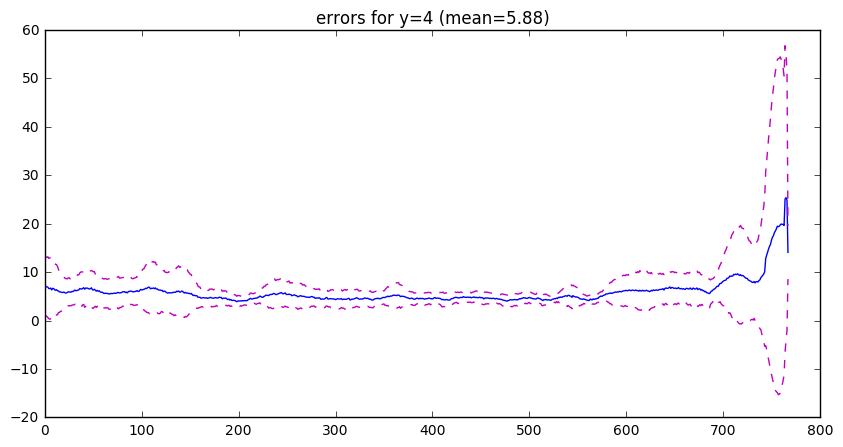

In [19]:
# Get estimated and true per-pixel estimates for the validation data
Y_hat_v = np.squeeze(Y_hat[valid_slices,...])
Y_v = np.squeeze(Y[valid_slices,...])


for yi in [0,1,2,3,4]:
    # estimated boundary
    f_regress = ppo.boundary_regression_1d    # TODO: tune hypers!
    B_hat = ppo.estimate_boundary(Y_hat_v, yi, f_regress)
    
    # True boundary can be extracted directly from dense ground truth
    B_true = np.nan * np.ones(B_hat.shape)
    for ii in range(B_true.shape[0]):
        rows, cols = ppo.get_class_transitions(Y_v[ii,...], yi)
        B_true[ii,cols] = rows
    
    # error metrics
    err_l1 = np.abs(B_hat - B_true)
    err_mu = np.nanmean(err_l1, axis=0)
    err_sigma = np.nanstd(err_l1, axis=0)
    
    
    # visualize result
    img = np.squeeze(X[valid_slices[show_idx],...])
    #img = un_mirror(img)
    xv = np.arange(img.shape[1])
    print(img.shape)
    print(Y_hat_v.shape)
    
    plt.figure(figsize=(10,5))
    plt.imshow(img, interpolation='none', cmap='gray')
    plt.plot(xv, B_hat[show_idx,:], 'y-', linewidth=2, label='est')
    plt.plot(xv, B_true[show_idx,:], 'm-', linewidth=2, label='true')
    plt.xlim([0, img.shape[-1]])
    plt.ylim([0, img.shape[-2]])
    plt.title('slice %d, y=%d' % (valid_slices[show_idx], yi))
    plt.legend()
    
    # Show aggregate results (on validation data)
    plt.figure(figsize=(10,5))
    plt.plot(xv, err_mu, 'b-', 
             xv, err_mu+err_sigma, 'm--',
             xv, err_mu-err_sigma, 'm--')
    #plt.errorbar(np.arange(B_hat.shape[1]), err_mu, err_sigma)
    plt.title('errors for y=%d (mean=%0.2f)' % (yi, np.mean(err_mu)))
    
    plt.show()